# Object Detection Batch inference with PyTorch

This example goes through how to do object detection at scale with a pre-trained model. In particular, we will introduce how to use Ray Datasets for **large-scale batch inference with multiple GPU workers.**

Here's what you'll do:

1. Load raw images and VOC-style annotations into a Dataset
2. Preprocess the images in the dataset in a distributed fashion
3. Load a pre-trained object detection model from `torchvision` and create a {class}`TorchPredictor <ray.train.torch.TorchPredictor>`
4. Do large-scale batch inference using multiple GPUs
5. Evaluate the prediction results against the ground truth labels.

## Before you begin

* Install the [Ray AI Runtime](air).

In [1]:
!pip install 'ray[air]' ipywidgets

* Install `torch`, `torchmetrics`, `torchvision`, and `xmltodict`.

In [2]:
!pip install torch torchmetrics torchvision xmltodict

## Step 1: Create a `Dataset`

The dataset that we will be using for prediction is a subset of [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) that contains cats and dogs (the full dataset has 20 classes).

The dataset contain two subdirectories: `JPEGImages` and `Annotations`. `JPEGImages` contains raw images, and
`Annotations` contains XML annotations.

```
AnimalDetection
├── Annotations
│   ├── 2007_000063.xml
│   ├── 2007_000528.xml
│   └──  ...
└── JPEGImages
    ├── 2007_000063.jpg
    ├── 2007_000528.jpg
    └──  ...
```

We can visualize one of the images, and we can see that it is an image of a dog

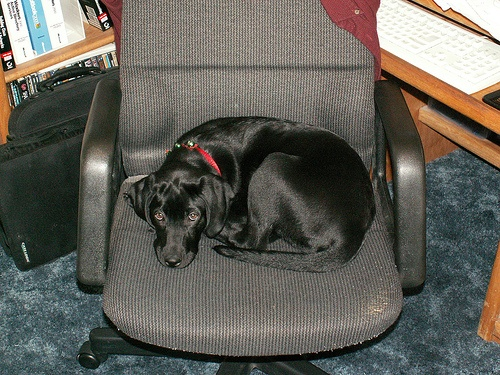

In [1]:
import io

from PIL import Image
import requests

response = requests.get("https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages/2007_000063.jpg")
image = Image.open(io.BytesIO(response.content))
image

### Load into a Ray Dataset

Let's now load in the images into a distributed Ray Dataset so we can do batch infernece. Because we are using a pre-trained model for inference only, we can just load in the images only and ignore the ground truth annotations for now.

We see that the resulting dataset has a single column called "image" which contains the images that we have loaded from S3.

In [2]:
import ray

ds = ray.data.read_images("s3://anonymous@air-example-data/AnimalDetection/JPEGImages")
ds

find: ‘.git’: No such file or directory
2023-04-05 20:29:08,487	INFO worker.py:1425 -- Connecting to existing Ray cluster at address: 10.0.58.156:6379...
2023-04-05 20:29:08,498	INFO worker.py:1613 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_miuf8zf43nwgkyjedf8zd7365f/services?redirect_to=dashboard 
2023-04-05 20:29:08,527	INFO packaging.py:347 -- Pushing file package 'gcs://_ray_pkg_50284dabbb676a9da3fd7e0d07ed57ea.zip' (9.00MiB) to Ray cluster...
2023-04-05 20:29:08,648	INFO packaging.py:360 -- Successfully pushed file package 'gcs://_ray_pkg_50284dabbb676a9da3fd7e0d07ed57ea.zip'.


### Visualize an image

Now that we have created our Ray Dataset, let's visualize one of the images to make sure everything looks good.

In [3]:
image_one_array = next(ds.iter_batches(batch_size=1, batch_format="numpy"))
image_one_array

{'image': array([array([[[172, 154, 144],
                [255, 248, 239],
                [255, 246, 244],
                ...,
                [255, 255, 246],
                [237, 234, 225],
                [214, 211, 202]],
 
               [[123, 105,  95],
                [255, 249, 240],
                [251, 244, 238],
                ...,
                [255, 252, 245],
                [255, 254, 247],
                [247, 244, 237]],
 
               [[ 54,  38,  25],
                [255, 253, 241],
                [250, 247, 238],
                ...,
                [248, 247, 243],
                [248, 247, 243],
                [254, 253, 249]],
 
               ...,
 
               [[ 64,  79,  86],
                [ 61,  74,  80],
                [104, 113, 118],
                ...,
                [ 94, 105, 109],
                [ 90,  99, 104],
                [ 83,  92,  97]],
 
               [[ 69,  86,  93],
                [ 68,  83,  88],
               

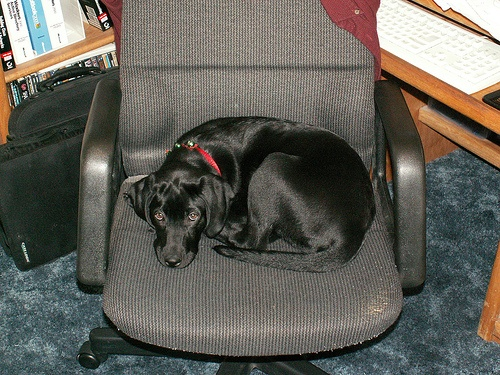

In [4]:
image_one = Image.fromarray(image_one_array["image"][0])
image_one

## Step 2: Prediction on a single image

Before doing full prediction at scale, let's start by testing out the end to end prediction flow on the single image from above. We will be following the guide from https://pytorch.org/vision/stable/models.html#object-detection

### Load the pre-trained model and transforms

For this example, let's use a pre-trained Faster R-CNN model with a Resnet-50 backbone from `torchvision`. 

This model is pre-trained using the [COCO dataset](https://cocodataset.org/#home), which contains 80 classes, including the cat and dog classes that we'll be detecting in this example.

In [5]:
from torchvision import models
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

weights = models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = models.detection.fasterrcnn_resnet50_fpn(weights=weights)

### Preprocessing the Image

The pre-trained weights also contains the TorchVision transforms to apply to our input dataset. We can extract the transforms from the weights and prepend it with a `ToTensor` transform to convert the numpy array to a PyTorch tensor.

In [6]:
object_detection_transforms = transforms.Compose([transforms.ToTensor(), weights.transforms()])
object_detection_transforms

Compose(
    ToTensor()
    ObjectDetection()
)

We can apply the transform directly on our image. We see that the resulting batch still has the "image" column, but the image is now transformed and is float32 instead of uint8.

In [9]:
from ray.air.util.tensor_extensions.utils import _create_possibly_ragged_ndarray

from ray.data.preprocessors.torch import TorchVisionPreprocessor

preprocessor = TorchVisionPreprocessor(columns=["image"], transform=object_detection_transforms)
transformed_image = preprocessor.transform_batch(image_one_array)
transformed_image

{'image': array([array([[[172, 154, 144],
                [255, 248, 239],
                [255, 246, 244],
                ...,
                [255, 255, 246],
                [237, 234, 225],
                [214, 211, 202]],
 
               [[123, 105,  95],
                [255, 249, 240],
                [251, 244, 238],
                ...,
                [255, 252, 245],
                [255, 254, 247],
                [247, 244, 237]],
 
               [[ 54,  38,  25],
                [255, 253, 241],
                [250, 247, 238],
                ...,
                [248, 247, 243],
                [248, 247, 243],
                [254, 253, 249]],
 
               ...,
 
               [[ 64,  79,  86],
                [ 61,  74,  80],
                [104, 113, 118],
                ...,
                [ 94, 105, 109],
                [ 90,  99, 104],
                [ 83,  92,  97]],
 
               [[ 69,  86,  93],
                [ 68,  83,  88],
               

### Prediction

Then, we can create a `TorchDetectionPredictor`. This is a built-in Predictor offered by Ray Train specifically for object detection with torchvision object detection models.

We also specify `feature_columns` to indicate that the `"image"` column contains the images that we want to infer on. We also specify `keep_columns` so that the `"image"` is still present in the prediction results

We see that the prediction batch contains the following data
- `"image"` which is the original image that we used for prediction
- `"pred_boxes"` which contains the bounding boxes for all the detections for each image
- `"pred_labels"` which contains the label for each detection
- `"pred_scores"` which contains the scores for each detection

In [10]:
from ray.train.torch import TorchDetectionPredictor

predictor = TorchDetectionPredictor(model=model)
prediction_batch = predictor.predict(transformed_image, feature_columns=["transformed_image"], keep_columns=["image"])
prediction_batch

2023-04-05 20:30:36,866	WARNING torch_predictor.py:57 -- You have `use_gpu` as False but there are 4 GPUs detected on host where prediction will only use CPU. Please consider explicitly setting `TorchPredictor(use_gpu=True)` or `batch_predictor.predict(ds, num_gpus_per_worker=1)` to enable GPU prediction.


{'pred_boxes': array([array([[122.52809   , 117.24522   , 377.2767    , 277.5271    ],
               [  2.714542  ,   0.        ,  34.7231    ,  65.69758   ],
               [ 24.756199  ,   0.        ,  56.40648   ,  59.41962   ],
               [  0.        ,  71.54452   , 113.58905   , 274.55798   ],
               [  1.3614078 ,  11.181082  ,  17.935183  ,  71.68596   ],
               [380.04773   ,   5.068189  , 497.63275   ,  95.89222   ],
               [ 36.81176   ,   0.        ,  65.134865  ,  55.51458   ],
               [ 52.146885  ,  69.179306  , 460.02753   , 359.51492   ],
               [  6.6527286 ,   0.        ,  80.2942    ,  64.84036   ],
               [ 78.79002   ,   0.85432506, 108.31155   ,  31.970806  ],
               [  8.244182  ,  80.80909   ,  20.504038  , 107.49327   ],
               [ 18.333529  ,  79.32639   ,  28.993153  , 103.48931   ],
               [  5.743632  ,  71.5172    , 109.310585  , 148.8642    ],
               [ 73.20486   ,  75.386

### Visualizing the prediction

Now that we have our detections, let's visualize them.

Let's see the top 3 objects with highest confidence that were detected in our image.

We'll use the `draw_bounding_boxes` utility from `torchvision`, therefore we need to convert the Numpy arrays to Torch tensors

We can see that the the top 3 detections are the dog, as well as 2 books.

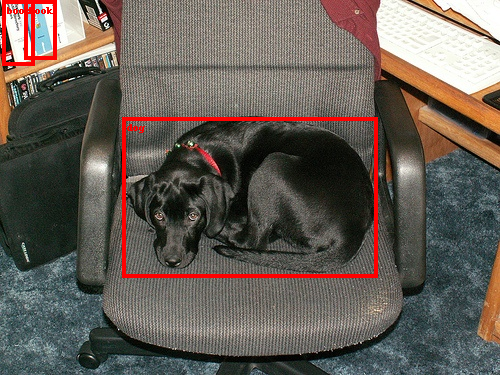

In [15]:
import torch
from torchvision.transforms.functional import convert_image_dtype, to_tensor
from torchvision.utils import draw_bounding_boxes

def plot(image, boxes, label_ids):
    label_ids = label_ids[:3]
    boxes = torch.as_tensor(boxes)[:3]
    image_tensor = convert_image_dtype(to_tensor(image), torch.uint8)

    labels = [weights.meta["categories"][i] for i in label_ids]
    box = draw_bounding_boxes(image_tensor, boxes=boxes,
                              labels=labels,
                              colors="red",
                              width=4)
    im = to_pil_image(box.detach())
    return im

im = plot(prediction_batch["image"][0], prediction_batch["pred_boxes"][0], prediction_batch["pred_labels"][0])
im

## Step 3: Scaling out to the full Dataset

Now that we've confirmed that we can accurately predict on a single image, let's scale this out to the full dataset. We can leverage the same `TorchVisionPreprocessor` and `TorchDetectionPredictor` that we used in the previous step.

First let's apply the preprocessor to our Dataset.

In [16]:
transformed_ds = ds.map_batches(preprocessor)

Then, we can apply the Predictor to get full prediction results.

Note that we have to do the following:
1. Specify that we want to use an `ActorPoolStrategy` compute so that the model can be initialized just once, and not for every batch.
2. Specify that we want 1 GPU for each prediction worker.
3. Pass in the `feature_columns` and `keep_columns` kwargs just like before.

In [17]:
predictions = transformed_ds.map_batches(predictor, 
                             compute=ray.data.ActorPoolStrategy(4, 4),
                             num_gpus=1,
                             batch_size=1,
                             fn_kwargs={"feature_columns": ["transformed_image"], "keep_columns": ["image"]})

# Trigger execution
predictions.cache()

2023-04-05 20:31:29,196	INFO batch_predictor.py:216 -- `num_gpus_per_worker` is set for `BatchPreditor`.Automatically enabling GPU prediction for this predictor. To disable set `use_gpu` to `False` in `BatchPredictor.predict`.
2023-04-05 20:31:29,797	INFO streaming_executor.py:87 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->TorchVisionPreprocessor] -> ActorPoolMapOperator[MapBatches(ScoringWrapper)]
Resource usage vs limits 0:   0%|          | 0/1 [00:00<?, ?it/s]2023-04-05 20:31:29,822	INFO actor_pool_map_operator.py:99 -- MapBatches(ScoringWrapper): Waiting for 4 pool actors to start...

ReadImage->TorchVisionPreprocessor 1:   0%|          | 0/200 [00:00<?, ?it/s]

MapBatches(ScoringWrapper) 2:   0%|          | 0/200 [00:00<?, ?it/s]


Resource usage vs limits: 0.0/48.0 CPU, 4.0/4.0 GPU, 0.0 MiB/12.91 GiB object_store_memory 0:   0%|          | 0/1 [00:01<?, ?it/s]


output: 0 queued 3:   0%|          | 0/200 [00:00<?, ?it/s]
ReadImage->TorchVisionPreproc

In [18]:
predictions

### Visualizing images

Now let's visualize the first 3 prediction results. We can use the same code we used before for visualizing the bounding boxes.

In [19]:
three_predictions = next(predictions.iter_batches(batch_format="numpy", batch_size=3))
three_predictions

{'pred_boxes': array([array([[122.52807   , 117.24521   , 377.2767    , 277.5271    ],
               [  2.71454   ,   0.        ,  34.7231    ,  65.69758   ],
               [ 24.756197  ,   0.        ,  56.406483  ,  59.419624  ],
               [  0.        ,  71.54451   , 113.589035  , 274.55795   ],
               [  1.361405  ,  11.181082  ,  17.935177  ,  71.68596   ],
               [380.04776   ,   5.0682    , 497.6327    ,  95.89223   ],
               [ 36.81177   ,   0.        ,  65.13488   ,  55.51457   ],
               [ 52.146854  ,  69.17926   , 460.0275    , 359.51495   ],
               [  6.652732  ,   0.        ,  80.294205  ,  64.84036   ],
               [ 78.790016  ,   0.85432506, 108.311554  ,  31.970806  ],
               [  8.244182  ,  80.80909   ,  20.504036  , 107.49327   ],
               [ 18.33353   ,  79.32639   ,  28.99315   , 103.48931   ],
               [  5.743632  ,  71.51719   , 109.31057   , 148.8642    ],
               [ 73.20486   ,  75.386

In [20]:
boxes = three_predictions["pred_boxes"]
label_ids = three_predictions["pred_labels"]
images = three_predictions["image"]

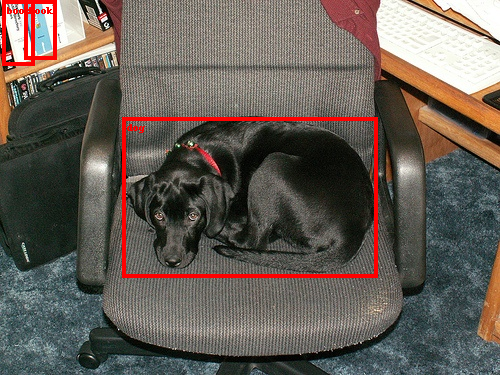

In [21]:
plot(images[0], boxes[0], label_ids[0])

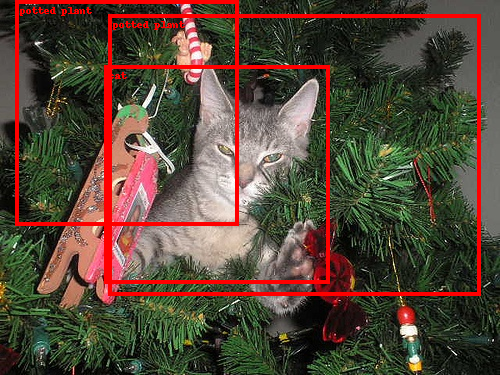

In [22]:
plot(images[1], boxes[1], label_ids[1])

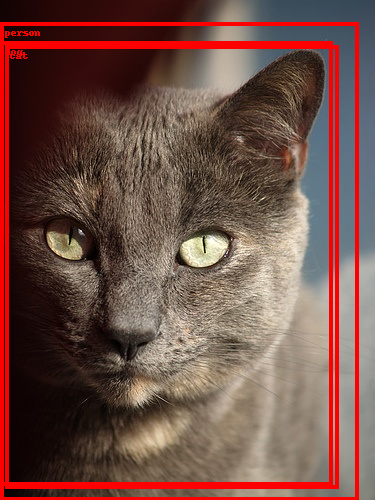

In [23]:
plot(images[2], boxes[2], label_ids[2])